In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb

In [2]:
CIF = pd.read_csv('data/TBN_CIF.csv',index_col='CUST_NO')  # 顧客基本資料
RECENT_DT = pd.read_csv('data/TBN_RECENT_DT.csv', na_values='a',index_col='CUST_NO')  #近期投資行為

CUST_BEHAVIOR = pd.read_csv('data/TBN_CUST_BEHAVIOR.csv', index_col='CUST_NO') #顧客瀏覽網頁行為
CUST_BEHAVIOR_raw = pd.read_csv('data/TBN_CUST_BEHAVIOR.csv') #顧客瀏覽網頁行為


CC_APPLY = pd.read_csv('data/TBN_CC_APPLY.csv') # 信用卡, priority 10
FX_TXN = pd.read_csv('data/TBN_FX_TXN.csv')    # 外匯, priority 1
LN_APPLY = pd.read_csv('data/TBN_LN_APPLY.csv')  # 信貸, priority 20
WM_TXN = pd.read_csv('data/TBN_WM_TXN.csv')  # 信託, priority 20

TBN = pd.read_csv('data/TBN_Y_ZERO.csv')  # 信託, priority 20

In [3]:
print('CIF shape:( %i, %i)'%(CIF.shape[0],CIF.shape[1]))
print('CUST_BEHAVIOR shape:( %i, %i)'%(CUST_BEHAVIOR.shape[0],CUST_BEHAVIOR.shape[1]))
print('CUST_BEHAVIOR_raw shape:( %i, %i)'%(CUST_BEHAVIOR_raw.shape[0],CUST_BEHAVIOR_raw.shape[1]))
print('RECENT_DT. shape:( %i, %i)'%(RECENT_DT.shape[0],RECENT_DT.shape[1]))
print('CC_APPLY shape:( %i, %i)'%(CC_APPLY.shape[0],CC_APPLY.shape[1]))
print('FX_TXN shape:( %i, %i)'%(FX_TXN.shape[0],FX_TXN.shape[1]))
print('LN_APPLY shape:( %i, %i)'%(LN_APPLY.shape[0],LN_APPLY.shape[1]))
print('WM_TXN shape:( %i, %i)'%(WM_TXN.shape[0],WM_TXN.shape[1]))
print('TBN shape:( %i, %i)'%(TBN.shape[0],TBN.shape[1]))

CIF shape:( 187679, 7)
CUST_BEHAVIOR shape:( 2209864, 2)
CUST_BEHAVIOR_raw shape:( 2209864, 3)
RECENT_DT. shape:( 195000, 4)
CC_APPLY shape:( 54393, 2)
FX_TXN shape:( 507185, 3)
LN_APPLY shape:( 6741, 4)
WM_TXN shape:( 36763, 5)
TBN shape:( 30000, 5)


In [4]:
print(CIF.head())
CIF.loc['W7ADZSWYXEMHB7JQ']

                  AGE  CHILDREN_CNT  CUST_START_DT  EDU_CODE GENDER_CODE  \
CUST_NO                                                                    
UFUIMEGMK2KTIWI4    1           NaN            2.0       NaN         NaN   
3HJN2X_LGBHBKILI    3           0.0         9393.0       NaN         NaN   
MNEZK2O3OE-JHYBW    4           0.0         2912.0       3.0           M   
W7ADZSWYXEMHB7JQ    4           0.0         8332.0       5.0           M   
ODB6BA6ORHL2UYZE    4           0.0          744.0       3.0           M   

                  INCOME_RANGE_CODE  WORK_MTHS  
CUST_NO                                         
UFUIMEGMK2KTIWI4                NaN        NaN  
3HJN2X_LGBHBKILI                1.0        NaN  
MNEZK2O3OE-JHYBW                2.0        2.0  
W7ADZSWYXEMHB7JQ                2.0        1.0  
ODB6BA6ORHL2UYZE                2.0        1.0  


AGE                     4
CHILDREN_CNT            0
CUST_START_DT        8332
EDU_CODE                5
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
Name: W7ADZSWYXEMHB7JQ, dtype: object

In [5]:
print(RECENT_DT.head())
RECENT_DT['CC_RECENT_DT']=RECENT_DT['CC_RECENT_DT'].fillna(0)
RECENT_DT['FX_RECENT_DT']=RECENT_DT['FX_RECENT_DT'].fillna(0)
RECENT_DT['LN_RECENT_DT']=RECENT_DT['LN_RECENT_DT'].fillna(0)
RECENT_DT['WM_RECENT_DT']=RECENT_DT['WM_RECENT_DT'].fillna(0)
print('CC_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['CC_RECENT_DT']), max(RECENT_DT['CC_RECENT_DT'])))
print('FX_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['FX_RECENT_DT']), max(RECENT_DT['FX_RECENT_DT'])))
print('LN_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['LN_RECENT_DT']), max(RECENT_DT['LN_RECENT_DT'])))
print('WM_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['WM_RECENT_DT']), max(RECENT_DT['WM_RECENT_DT'])))

                  CC_RECENT_DT  FX_RECENT_DT  LN_RECENT_DT  WM_RECENT_DT
CUST_NO                                                                 
UTYYSZRISTNCDCGU           NaN           NaN           NaN           NaN
4IKO82Q8ZY2X2VAK           NaN           NaN           NaN           NaN
EP2OI8DQMZFAHBEA        9214.0           NaN           NaN           NaN
83A1N8HQ4CLT56IY        9393.0        9438.0           NaN        9368.0
SURN2CDMNHCL4SJC        7318.0        9445.0           NaN        8154.0
CC_RECENT_DT: 0.0, 9447.0 
FX_RECENT_DT: 0.0, 9447.0 
LN_RECENT_DT: 0.0, 9445.0 
WM_RECENT_DT: 0.0, 9445.0 


In [6]:
print(CUST_BEHAVIOR.head())
print('VISITDATE: %.1f, %.1f '%(min(CUST_BEHAVIOR['VISITDATE']), max(CUST_BEHAVIOR['VISITDATE'])))

                  VISITDATE                                               PAGE
CUST_NO                                                                       
AZTHNWQ_LXMGIMYG       9462      http://www.esunbank.com.tw/gygrt/e2c/iougkjr/
AZTHNWQ_LXMGIMYG       9528  https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
3PY428CHUQBULFIG       9458  https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...
JVPD1QUJWVLMZU8S       9457  https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
JVPD1QUJWVLMZU8S       9485  https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
VISITDATE: 9448.0, 9567.0 


In [7]:
print(CC_APPLY.head())
print('CC_TXN_DT: %i, %i '%(min(CC_APPLY['TXN_DT']), max(CC_APPLY['TXN_DT'])))

            CUST_NO  TXN_DT
0  8H_N_K5ICM4NU7OG    9519
1  HXD9GCY3SPIYLJS0    9451
2  KSBOZ-TBPUDD9NMO    9502
3  MU8ROCNFDGSL0HJC    9549
4  RGZZAUSNHNXXESM4    9561
CC_TXN_DT: 9448, 9567 


In [8]:
print(FX_TXN.head())
print('FX_TXN_DT: %i, %i '%(min(FX_TXN['TXN_DT']), max(FX_TXN['TXN_DT'])))

            CUST_NO  TXN_DT  FX_TXN_AMT
0  MNEZK2O3OE-JHYBW    9562       26006
1  MNEZK2O3OE-JHYBW    9567       26009
2  MNEZK2O3OE-JHYBW    9557       26793
3  MNEZK2O3OE-JHYBW    9452       25981
4  MNEZK2O3OE-JHYBW    9451       26002
FX_TXN_DT: 9448, 9567 


In [9]:
print(LN_APPLY.head())
print('LN_TXN_DT: %i, %i '%(min(LN_APPLY['TXN_DT']), max(LN_APPLY['TXN_DT'])))

            CUST_NO  TXN_DT   LN_AMT LN_USE
0  JZKEGB1J3FEPXGWA    9455   904731     06
1  TKTH9UXLWDVLA8E4    9472  1218170     01
2  KZ0XPLZI-NGTHTDE    9505  1183088     01
3  BT5INBWYOZQK8CDY    9457   848097     05
4  Z5H7IUX8VPUMWWY8    9473   848097     01
LN_TXN_DT: 9449, 9567 


In [10]:
print(WM_TXN.head())
print('WM_TXN_DT: %i, %i '%(min(WM_TXN['TXN_DT']), max(WM_TXN['TXN_DT'])))

            CUST_NO  TXN_DT  CUST_RISK_CODE  INVEST_TYPE_CODE  WM_TXN_AMT
0  83A1N8HQ4CLT56IY    9476             3.0                 2      270684
1  B8ZNLMVWJOHCJ7LY    9546             3.0                 2      254794
2  -O2NVMT-W0WJHEAQ    9521             3.0                 2      797298
3  NRVZ15KRUYBNVLX0    9490             4.0                 2      439191
4  GAP3CQTQ-3K8OAHM    9513             4.0                 2      137037
WM_TXN_DT: 9449, 9567 


## 1. 訓練資料集時間為 9447+1 (9448) ~ 9447+120 (9567) 之間，共120日之間產品交易/申請資訊．
## 2. 本次比賽是請參賽者預測在9447+121 (9568) ~ 9447+150 (9597) 時間區間內（共30日），顧客在四個產品線CC_IND, FX_IND, LN_IND, WM_IND是否會進行交易，若預測顧客該時間內於任一產品線交易一次以上，該產品線的預測值為1，否則為0．例如: 顧客序號12345，預測信用卡核卡1次，外匯交易2次，沒有信貸申請，信託交易3次，該筆預測資料應為: 12345,1,1,0,1 ．
## 3. TBN_Y_ZERO.csv則是提供給參賽者做為上傳範例資料檔使用，內部預設值是全部為0．

In [11]:
a=WM_TXN.groupby('CUST_NO', sort=False).max()

In [12]:
a
#a.loc['B8ZNLMVWJOHCJ7LY']

,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,
83A1N8HQ4CLT56IY,9476,3.0,2,270684
B8ZNLMVWJOHCJ7LY,9546,3.0,2,784000
-O2NVMT-W0WJHEAQ,9521,3.0,2,1032539
NRVZ15KRUYBNVLX0,9490,4.0,2,439191
GAP3CQTQ-3K8OAHM,9513,4.0,2,137037
IQAYHLFYJGS7I6AI,9525,4.0,2,505049
VUDTJZYRXZFQXE2I,9464,4.0,2,1364860
OSYKGFITHMN-PB4K,9528,4.0,2,634813
DTQWITQ8OWL75KUQ,9463,4.0,2,605885


In [13]:
WM = pd.concat((CIF,RECENT_DT ,a), axis=1, join_axes=[CIF.index], ignore_index=False)
print(WM.loc['SURN2CDMNHCL4SJC'])
#print(WM[WM['CUST_RISK_CODE']>0])
#print(WM[WM['WM_TXN_AMT']>0])
WM

AGE                     4
CHILDREN_CNT            0
CUST_START_DT        4677
EDU_CODE                2
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
CC_RECENT_DT         7318
FX_RECENT_DT         9445
LN_RECENT_DT            0
WM_RECENT_DT         8154
TXN_DT                NaN
CUST_RISK_CODE        NaN
INVEST_TYPE_CODE      NaN
WM_TXN_AMT            NaN
Name: SURN2CDMNHCL4SJC, dtype: object


,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,,,,,,,,,,,,
UFUIMEGMK2KTIWI4,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3HJN2X_LGBHBKILI,3,0.0,9393.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MNEZK2O3OE-JHYBW,4,0.0,2912.0,3.0,M,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W7ADZSWYXEMHB7JQ,4,0.0,8332.0,5.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ODB6BA6ORHL2UYZE,4,0.0,744.0,3.0,M,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SURN2CDMNHCL4SJC,4,0.0,4677.0,2.0,M,2.0,1.0,7318.0,9445.0,0.0,8154.0,NaN,NaN,NaN,NaN
1SMBYIP5SSUNG1DW,4,0.0,7936.0,6.0,M,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8H_N_K5ICM4NU7OG,4,0.0,3502.0,3.0,M,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OGMWH3NPW4BKLRBU,4,0.0,5418.0,3.0,M,2.0,1.0,5410.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [14]:
WM = pd.concat((CIF,RECENT_DT), axis=1, join_axes=[RECENT_DT.index], ignore_index=False)
print(WM.loc['SURN2CDMNHCL4SJC'])
#print(WM[WM['CUST_RISK_CODE']>0])
#print(WM[WM['WM_TXN_AMT']>0])
WM.shape

AGE                     4
CHILDREN_CNT            0
CUST_START_DT        4677
EDU_CODE                2
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
CC_RECENT_DT         7318
FX_RECENT_DT         9445
LN_RECENT_DT            0
WM_RECENT_DT         8154
Name: SURN2CDMNHCL4SJC, dtype: object


(195000, 11)

In [15]:


print(max(CUST_BEHAVIOR['VISITDATE']))
CUST_B_over30 = CUST_BEHAVIOR[CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)]
CUST_B_30_60 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-60))]
CUST_B_60_90 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-60)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-90))]
CUST_B_90_120 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-90)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-120))]
CUST_B_in30 = CUST_BEHAVIOR[CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-30)]
print('Over 30 days, max day: %i' %max(CUST_B_over30['VISITDATE']))
print(' 30~60  days, max day: %i' %max(CUST_B_30_60['VISITDATE']))
print(' 60~90  days, max day: %i' %max(CUST_B_60_90['VISITDATE']))
print(' 90~120  days, max day: %i' %max(CUST_B_90_120['VISITDATE']))
print('  in 30 days, min day: %i' %min(CUST_B_in30['VISITDATE']))
#print(CUST_B_over30.shape)
print(CUST_B_30_60.shape)
print(CUST_B_60_90.shape)
print(CUST_B_90_120.shape)
print(CUST_B_in30.shape)

9567
Over 30 days, max day: 9537
 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(649891, 2)
(601314, 2)
(760446, 2)
(198213, 2)


In [16]:

print(max(CUST_BEHAVIOR_raw['VISITDATE']))
CUST_B_over30_raw = CUST_BEHAVIOR_raw[CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)]
CUST_B_30_60_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-60))]
CUST_B_60_90_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-60)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-90))]
CUST_B_90_120_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-90)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-120))]
CUST_B_in30_raw = CUST_BEHAVIOR_raw[CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)]
print('Over 30 days, max day: %i' %max(CUST_B_over30_raw['VISITDATE']))
print(' 30~60  days, max day: %i' %max(CUST_B_30_60_raw['VISITDATE']))
print(' 60~90  days, max day: %i' %max(CUST_B_60_90_raw['VISITDATE']))
print(' 90~120  days, max day: %i' %max(CUST_B_90_120_raw['VISITDATE']))
print('  in 30 days, min day: %i' %min(CUST_B_in30_raw['VISITDATE']))
#print(CUST_B_over30.shape)
print(CUST_B_30_60_raw.shape)
print(CUST_B_60_90_raw.shape)
print(CUST_B_90_120_raw.shape)
print(CUST_B_in30_raw.shape)

9567
Over 30 days, max day: 9537
 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(649891, 3)
(601314, 3)
(760446, 3)
(198213, 3)


In [17]:
CUST_BEHAVIOR.shape

(2209864, 2)

In [18]:
#total page count
PAGE_count = CUST_BEHAVIOR.groupby('PAGE').max()
PAGE_count.shape

(782, 1)

In [19]:
# 瀏覽網頁總人數
CUST_BEHAVIOR_gb = CUST_BEHAVIOR.groupby(('CUST_NO'), sort=False).max()
CUST_BEHAVIOR_gb.shape 

(195000, 2)

In [20]:
# 30~120天瀏覽人數
CUST_B_over30_gb = CUST_B_over30.groupby(('CUST_NO'), sort=False).max()
CUST_B_over30_gb.shape

(180000, 2)

In [21]:
# 30~60 天瀏覽人數
CUST_B_30_60_gb = CUST_B_30_60.groupby(('CUST_NO'), sort=False).max()
print(CUST_B_30_60_gb.shape)
CUST_B_30_60_gb.head()

(86867, 2)


,VISITDATE,PAGE
CUST_NO,,
AZTHNWQ_LXMGIMYG,9528,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
KCAFRIBOU9F2SSJW,9511,https://www.esunbank.com.tw/gygrt/cugfkt/10603...
JDVF4U8JUANEID68,9537,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...
YXAILWW0FSCXRY2A,9520,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
QAQSXBTCGA0SRGAO,9534,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...


In [22]:
# 60~90 天瀏覽人數
CUST_B_60_90_gb = CUST_B_60_90.groupby(('CUST_NO'), sort=False).max()
CUST_B_60_90_gb.shape

(86911, 2)

In [23]:
# 90~120 天瀏覽人數
CUST_B_90_120_gb = CUST_B_90_120.groupby(('CUST_NO'), sort=False).max()
CUST_B_90_120_gb.shape

(92858, 2)

In [24]:
# 近 30天瀏覽人數
CUST_B_in30_gb = CUST_B_in30.groupby(('CUST_NO'), sort=False).max()
CUST_B_in30_gb.shape

(30000, 2)

In [25]:
#CUST_B_in30_gb.to_csv('C_B_in30.csv')

In [26]:
# 30~60 天資料筆數
CUST_B_30_60_gbp = CUST_B_30_60_raw.groupby(('CUST_NO', 'PAGE'), sort=False).max()
CUST_B_30_60_gbp.shape


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


(197002, 1)

In [27]:
WM_TXN.head()

,CUST_NO,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
0,83A1N8HQ4CLT56IY,9476,3.0,2,270684
1,B8ZNLMVWJOHCJ7LY,9546,3.0,2,254794
2,-O2NVMT-W0WJHEAQ,9521,3.0,2,797298
3,NRVZ15KRUYBNVLX0,9490,4.0,2,439191
4,GAP3CQTQ-3K8OAHM,9513,4.0,2,137037


In [28]:
max(WM_TXN['TXN_DT'])

9567

## 將 WM 分群

In [29]:
WM_30_60 = WM_TXN[(WM_TXN['TXN_DT']<=(max(WM_TXN['TXN_DT'])-30)) & (WM_TXN['TXN_DT']>(max(WM_TXN['TXN_DT'])-60))]
WM_60_90 = WM_TXN[(WM_TXN['TXN_DT']<=(max(WM_TXN['TXN_DT'])-60)) & (WM_TXN['TXN_DT']>(max(WM_TXN['TXN_DT'])-90))]
WM_90_120 = WM_TXN[(WM_TXN['TXN_DT']<=(max(WM_TXN['TXN_DT'])-90)) & (WM_TXN['TXN_DT']>(max(WM_TXN['TXN_DT'])-120))]
WM_in30 = WM_TXN[WM_TXN['TXN_DT']>(max(WM_TXN['TXN_DT'])-30)]

print(' 30~60  days, max day: %i' %max(WM_30_60['TXN_DT']))
print(' 60~90  days, max day: %i' %max(WM_60_90['TXN_DT']))
print(' 90~120  days, max day: %i' %max(WM_90_120['TXN_DT']))
print('  in 30 days, min day: %i' %min(WM_in30['TXN_DT']))

print(WM_30_60.shape)
print(WM_60_90.shape)
print(WM_90_120.shape)
print(WM_in30.shape)

 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9539
(8674, 5)
(9517, 5)
(9986, 5)
(8586, 5)


In [30]:
# 近30天WM人數
WM_in30_gb = WM_in30.groupby(('CUST_NO'), sort=False).max()
print(WM_in30_gb.shape)
WM_in30_gb.head()

(5310, 4)


,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,
B8ZNLMVWJOHCJ7LY,9546,3.0,2,254794
FXBJ1NLZXNHF6VP4,9560,4.0,2,318417
B-BVEF_K1PTVXOHA,9550,4.0,2,505049
_KGNHONXVGE6MIGC,9562,3.0,2,1413013
2DIVB_AUHB_TMH-K,9546,3.0,2,439191


In [31]:
#30~60天WM人數
WM_30_60_gb = WM_30_60.groupby(('CUST_NO'), sort=False).max()
print(WM_30_60_gb.shape)
WM_30_60_gb.head()

(5008, 4)


,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,
-O2NVMT-W0WJHEAQ,9521,3.0,2,1032539
GAP3CQTQ-3K8OAHM,9513,4.0,2,137037
IQAYHLFYJGS7I6AI,9525,4.0,2,505049
OSYKGFITHMN-PB4K,9528,4.0,2,634813
BCXKB8HF7LUJ6IO0,9519,4.0,2,605885


In [32]:
#60~90天WM人數
WM_60_90_gb = WM_60_90.groupby(('CUST_NO'), sort=False).max()
print(WM_60_90_gb.shape)
WM_60_90_gb.head()

(5010, 4)


,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,
NRVZ15KRUYBNVLX0,9490,4.0,2,439191
RC7C8-OIJPD5SD9M,9500,4.0,2,505049
TJ79BRJ88TAJWA3S,9507,4.0,2,605885
IOQO49ATS-V1AH9U,9507,3.0,2,605885
NRHCAEGOVDNGWLN0,9491,4.0,2,505394


In [33]:
#90~120天WM人數
WM_90_120_gb = WM_90_120.groupby(('CUST_NO'), sort=False).max()
print(WM_90_120_gb.shape)
WM_90_120_gb.head()

(5153, 4)


,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,
83A1N8HQ4CLT56IY,9476,3.0,2,270684
VUDTJZYRXZFQXE2I,9464,4.0,2,1364860
DTQWITQ8OWL75KUQ,9463,4.0,2,605885
TJ79BRJ88TAJWA3S,9459,4.0,2,634813
_KGNHONXVGE6MIGC,9476,3.0,2,439191


## 將 WM 弄成 boolean, 且改為Y

In [34]:
# 將 WM 弄成 boolean, 且改為Y
print(WM_in30_gb.shape)
WM_in_30_Y = pd.DataFrame(WM_in30_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
WM_in_30_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(WM_in_30_Y.shape)
WM_in_30_Y.head()

(5310, 4)
(5310, 1)


,y
CUST_NO,
B8ZNLMVWJOHCJ7LY,True
FXBJ1NLZXNHF6VP4,True
B-BVEF_K1PTVXOHA,True
_KGNHONXVGE6MIGC,True
2DIVB_AUHB_TMH-K,True


In [35]:
print(WM_30_60_gb.shape)
WM_30_60_Y = pd.DataFrame(WM_30_60_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
WM_30_60_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(WM_30_60_Y.shape)
WM_30_60_Y.head()

(5008, 4)
(5008, 1)


,y
CUST_NO,
-O2NVMT-W0WJHEAQ,True
GAP3CQTQ-3K8OAHM,True
IQAYHLFYJGS7I6AI,True
OSYKGFITHMN-PB4K,True
BCXKB8HF7LUJ6IO0,True


In [36]:
print(WM_60_90_gb.shape)
WM_60_90_Y = pd.DataFrame(WM_60_90_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
WM_60_90_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(WM_60_90_Y.shape)
WM_60_90_Y.head()

(5010, 4)
(5010, 1)


,y
CUST_NO,
NRVZ15KRUYBNVLX0,True
RC7C8-OIJPD5SD9M,True
TJ79BRJ88TAJWA3S,True
IOQO49ATS-V1AH9U,True
NRHCAEGOVDNGWLN0,True


80MMPXAEOOBMLLZS
BVGAT9FJOQKNOXD0
EBI_G_XSTJUYVY9W
VI6OOMENGNASXNZG


https://www.esunbank.com.tw/gygrt/cugfkt/1060222gcdufqodr/krfgz.htm
    https://www.esunbank.com.tw/gygrt/cugfkt/1070210pda_dppqg/

In [37]:
# 第一組 training data
DATA_30_60 = pd.concat((CUST_B_30_60,CIF,RECENT_DT, WM_30_60_gb, WM_in_30_Y), axis=1 ,join_axes=[CUST_B_30_60.index])
print(DATA_30_60.shape)
DATA_30_60.loc['VI6OOMENGNASXNZG']#.head()


(649891, 18)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,y
CUST_NO,,,,,,,,,,,,,,,,,,
VI6OOMENGNASXNZG,9527,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8967.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,True
VI6OOMENGNASXNZG,9527,https://www.esunbank.com.tw/gygrt/cugfkt/10702...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8967.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,True


In [38]:
# 使用網路且真的在下個月有WM行為的數量
DATA_30_60[DATA_30_60['y']==True]
DATA_30_60_WM = pd.concat((CUST_B_30_60_gb,CIF,RECENT_DT, WM_30_60_gb, WM_in_30_Y), axis=1 ,join_axes=[WM_in_30_Y.index])
# 實際WM數量
print(DATA_30_60_WM.shape)
# 未使用網路卻交易數量
DATA_30_60_WM[DATA_30_60_WM['PAGE'].isnull()].shape

(5310, 18)


(3827, 18)

In [39]:
# 第二組 training data
DATA_60_90 = pd.concat((CUST_B_60_90,CIF,RECENT_DT, WM_60_90_gb, WM_30_60_Y), axis=1 ,join_axes=[CUST_B_60_90.index])
print(DATA_60_90.shape)
DATA_60_90.loc['3XTU38XKEMDMVJZI']#.loc['3XTU38XKEMDMVJZI']#

(601314, 18)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,y
CUST_NO,,,,,,,,,,,,,,,,,,
3XTU38XKEMDMVJZI,9478,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9478,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9479,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9478,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9484,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9483,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9504,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9496,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9500,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9504.0,4.0,1.0,1364860.0,True


In [40]:
# 使用網路且真的在下個月有WM行為的數量
DATA_60_90[DATA_60_90['y']==True]
DATA_60_90_WM = pd.concat((CUST_B_60_90_gb,CIF,RECENT_DT, WM_60_90_gb, WM_30_60_Y), axis=1 ,join_axes=[WM_30_60_Y.index])
# 實際WM數量
print(DATA_60_90_WM.shape)
# 未使用網路卻交易數量
DATA_60_90_WM[DATA_60_90_WM['PAGE'].isnull()].shape

(5008, 18)


(3571, 18)

In [41]:
# 第三組 training data
DATA_90_120 = pd.concat((CUST_B_90_120,CIF,RECENT_DT, WM_90_120_gb, WM_60_90_Y), axis=1 ,join_axes=[CUST_B_90_120.index])
print(DATA_90_120.shape)
DATA_90_120.loc['3XTU38XKEMDMVJZI']#.loc['3XTU38XKEMDMVJZI']#

(760446, 18)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT,y
CUST_NO,,,,,,,,,,,,,,,,,,
3XTU38XKEMDMVJZI,9449,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9449,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9476,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9458,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9465,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9469,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9471,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9471,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True
3XTU38XKEMDMVJZI,9473,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,9465.0,4.0,1.0,1364860.0,True


In [42]:
# 使用網路且真的在下個月有WM行為的數量
DATA_90_120[DATA_90_120['y']==True]
DATA_90_120_WM = pd.concat((CUST_B_90_120_gb,CIF,RECENT_DT, WM_90_120_gb, WM_60_90_Y), axis=1 ,join_axes=[WM_60_90_Y.index])
# 實際WM數量
print(DATA_90_120_WM.shape)
# 未使用網路卻交易數量
DATA_90_120_WM[DATA_90_120_WM['PAGE'].isnull()].shape

(5010, 18)


(3429, 18)

In [43]:
#DATA = pd.concat((DATA_30_60,DATA_60_90,DATA_90_120), axis=0)
DATA = DATA_30_60
DATA.shape

(649891, 18)

In [44]:
test1 = pd.concat((CUST_B_in30,CIF,RECENT_DT, WM_in30_gb), axis=1 ,join_axes=[CUST_B_in30.index])
print(test1.shape)
test1.loc['8I6SQDGP9OQYUN1M']

(198213, 17)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,CUST_RISK_CODE,INVEST_TYPE_CODE,WM_TXN_AMT
CUST_NO,,,,,,,,,,,,,,,,,
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,9561.0,3.0,2.0,439191.0
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/wgdqth/ixrfpq...,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,9561.0,3.0,2.0,439191.0
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/wgdqth/ixrfpq...,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,9561.0,3.0,2.0,439191.0


In [45]:
ntrain = DATA.shape[0]
ntest = test1.shape[0]
all_data = pd.concat((DATA, test1))
print(ntrain)
print(ntest)
all_data.shape

649891
198213


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


(848104, 18)

In [46]:
all_data.head()

,AGE,CC_RECENT_DT,CHILDREN_CNT,CUST_RISK_CODE,CUST_START_DT,EDU_CODE,FX_RECENT_DT,GENDER_CODE,INCOME_RANGE_CODE,INVEST_TYPE_CODE,LN_RECENT_DT,PAGE,TXN_DT,VISITDATE,WM_RECENT_DT,WM_TXN_AMT,WORK_MTHS,y
CUST_NO,,,,,,,,,,,,,,,,,,
AZTHNWQ_LXMGIMYG,3.0,0.0,0.0,NaN,7945.0,NaN,0.0,M,1.0,NaN,0.0,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...,NaN,9528,0.0,NaN,NaN,NaN
KCAFRIBOU9F2SSJW,NaN,6396.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,https://www.esunbank.com.tw/gygrt/cugfkt/10603...,NaN,9511,8146.0,NaN,NaN,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,NaN,2484.0,3.0,9442.0,F,4.0,NaN,0.0,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,NaN,9535,9442.0,NaN,1.0,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,NaN,2484.0,3.0,9442.0,F,4.0,NaN,0.0,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,NaN,9537,9442.0,NaN,1.0,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,NaN,2484.0,3.0,9442.0,F,4.0,NaN,0.0,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...,NaN,9535,9442.0,NaN,1.0,NaN


In [47]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
# 沒有missing的拿掉, 以遞減方式列出有missing的feature
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] 
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
y,96.955444
CUST_RISK_CODE,96.157429
WM_TXN_AMT,96.123235
TXN_DT,96.123235
INVEST_TYPE_CODE,96.123235
WORK_MTHS,36.759171
EDU_CODE,30.890433
GENDER_CODE,22.252695
CHILDREN_CNT,21.503966
INCOME_RANGE_CODE,21.487105


In [48]:
all_data['y'] = all_data['y'].fillna(False)

In [49]:

for col in ('LN_RECENT_DT','WM_RECENT_DT','FX_RECENT_DT','CC_RECENT_DT','WM_TXN_AMT','TXN_DT','CUST_START_DT'):
    all_data[col] = all_data[col].fillna(0)

In [50]:
for col in ('CUST_RISK_CODE', 'INVEST_TYPE_CODE', 'WORK_MTHS','EDU_CODE', 'GENDER_CODE', 'CHILDREN_CNT','INCOME_RANGE_CODE','AGE'):
    all_data[col] = all_data[col].fillna('None')

In [51]:
#all_data['y_True']

In [52]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
# 沒有missing的拿掉, 以遞減方式列出有missing的feature
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] 
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [53]:
#DATA_30_60[DATA_30_60['y']==True]

In [54]:
all_data = pd.get_dummies(all_data)
all_data.shape

(848104, 705)

In [55]:
train = all_data[:ntrain]
ytrain = train['y']
test = all_data[ntrain:]


In [56]:

train = train.drop(['y'], axis=1)
test = test.drop(['y'], axis=1)

In [57]:
print(train.shape)
print(ytrain.shape)
print(test.shape)

(649891, 704)
(649891,)
(198213, 704)


In [58]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split


X_train1, X_test1, y_train1, y_test1 = train_test_split(train, ytrain, random_state = np.random.randint(1,999), test_size = 0.20) #

In [59]:
print(X_train1.shape)
print(y_train1.shape)

(519912, 704)
(519912,)


In [60]:
# eval_set =  [(X_test1, y_test1)]
# model = XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
#        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
#        reg_alpha=0.1, reg_lambda=1,  seed=None,
#        silent=True, subsample=0.9)
# model.fit(X_train1, y_train1, early_stopping_rounds=50, eval_metric="error", eval_set=eval_set,verbose=True)

In [85]:
eval_set =  [(X_test1, y_test1)]
model = XGBClassifier(scale_pos_weight=1,n_estimators=1500, learning_rate=0.1,max_depth=3)
# model = XGBClassifier(scale_pos_weight=2.13,n_estimators=150, learning_rate=0.03)

In [86]:
model.fit(X_train1, y_train1, eval_metric="error", eval_set=eval_set,verbose=True, early_stopping_rounds=20)

[0]	validation_0-error:0.031705
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.031336
[2]	validation_0-error:0.031267
[3]	validation_0-error:0.031067
[4]	validation_0-error:0.031082
[5]	validation_0-error:0.031274
[6]	validation_0-error:0.031274
[7]	validation_0-error:0.031274
[8]	validation_0-error:0.031728
[9]	validation_0-error:0.030013
[10]	validation_0-error:0.029943
[11]	validation_0-error:0.029874
[12]	validation_0-error:0.029882
[13]	validation_0-error:0.029813
[14]	validation_0-error:0.029774
[15]	validation_0-error:0.029828
[16]	validation_0-error:0.029505
[17]	validation_0-error:0.029489
[18]	validation_0-error:0.029728
[19]	validation_0-error:0.029697
[20]	validation_0-error:0.02962
[21]	validation_0-error:0.029528
[22]	validation_0-error:0.029689
[23]	validation_0-error:0.029605
[24]	validation_0-error:0.029505
[25]	validation_0-error:0.029405
[26]	validation_0-error:0.029512
[27]	validation_0-error:0.029505
[28]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
predicted=model.predict(X_test1)
print(accuracy_score(predicted, y_test1))

print(classification_report(y_test1,predicted ))
confusion_matrix(y_test1,predicted)
confusion_matrix(predicted,y_test1)

0.9815431723586118
             precision    recall  f1-score   support

      False       0.98      1.00      0.99    124841
       True       0.93      0.58      0.71      5138

avg / total       0.98      0.98      0.98    129979



/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[124603,   2161],
       [   238,   2977]])

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
predicted=model.predict(X_test1)
print(accuracy_score(predicted, y_test1))

print(classification_report(y_test1,predicted ))
confusion_matrix(y_test1,predicted)
confusion_matrix(predicted,y_test1)

0.9903907554297232
             precision    recall  f1-score   support

      False       0.99      1.00      1.00    124719
       True       0.99      0.77      0.87      5260

avg / total       0.99      0.99      0.99    129979



/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[124672,   1202],
       [    47,   4058]])

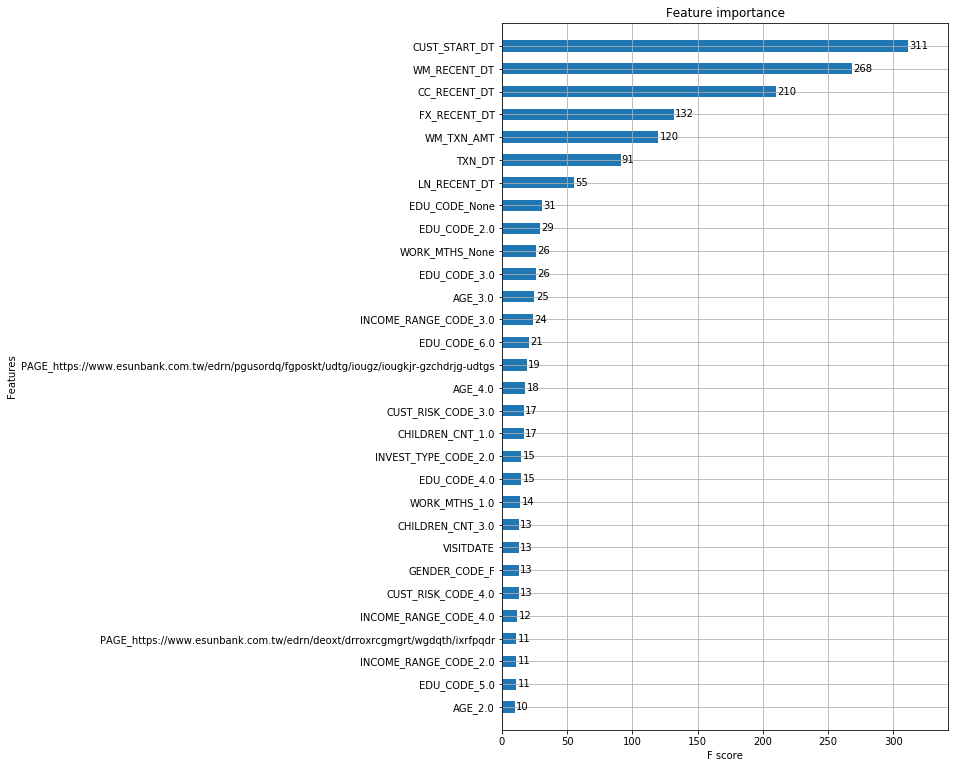

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=30, height=0.5, ax=ax)

In [89]:
if test.shape[1] > X_test1.shape[1]:
    test=test.drop('y',axis=1)

In [90]:
model.predict(test)
test['y'] = model.predict(test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
test.shape

(198213, 705)

In [92]:
test.head()

,CC_RECENT_DT,CUST_START_DT,FX_RECENT_DT,LN_RECENT_DT,TXN_DT,VISITDATE,WM_RECENT_DT,WM_TXN_AMT,AGE_1.0,AGE_2.0,...,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot/,WORK_MTHS_1.0,WORK_MTHS_2.0,WORK_MTHS_3.0,WORK_MTHS_4.0,WORK_MTHS_5.0,WORK_MTHS_None,y
CUST_NO,,,,,,,,,,,,,,,,,,,,,
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9553,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9553,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9553,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9554,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,9562,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False


In [93]:
test.groupby(test.index).max().shape

(30000, 705)

In [94]:
# 查看 test 資料預測為 True的數量
y_final = test.groupby(test.index, sort=False).max()
print(y_final[y_final['y']==True].shape[0])
y_final[y_final['y']==True]

362


,CC_RECENT_DT,CUST_START_DT,FX_RECENT_DT,LN_RECENT_DT,TXN_DT,VISITDATE,WM_RECENT_DT,WM_TXN_AMT,AGE_1.0,AGE_2.0,...,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot/,WORK_MTHS_1.0,WORK_MTHS_2.0,WORK_MTHS_3.0,WORK_MTHS_4.0,WORK_MTHS_5.0,WORK_MTHS_None,y
CUST_NO,,,,,,,,,,,,,,,,,,,,,
PQUP4ESIA0DT5HQE,9259.0,5014.0,9443.0,0.0,9567.0,9567,9402.0,505049.0,0,0,...,0,0,0,0,1,0,0,0,0,True
VJHXGPWJKH2OHMGI,6149.0,1479.0,9330.0,0.0,9553.0,9539,9154.0,1550256.0,0,0,...,0,0,0,1,0,0,0,0,0,True
SVYPKK8KTIIV-6SG,9370.0,6739.0,9408.0,0.0,9547.0,9567,0.0,213240.0,1,0,...,0,0,0,1,0,0,0,0,0,True
39PI8JX6WDCJBB2I,8794.0,3968.0,9444.0,9211.0,9550.0,9566,9385.0,509070.0,0,0,...,0,0,0,1,0,0,0,0,0,True
63XILNAP_KCXM-BU,0.0,6193.0,0.0,0.0,9554.0,9541,8335.0,505049.0,0,0,...,0,0,0,0,0,0,0,0,1,True
V0OESJAKMOHMP48K,8245.0,2121.0,9385.0,0.0,9548.0,9564,9389.0,439191.0,0,0,...,0,0,0,1,0,0,0,0,0,True
IDEFJNQ60TQHLW_G,0.0,8351.0,9095.0,0.0,9547.0,9546,9424.0,1165775.0,0,1,...,0,0,0,0,0,0,0,0,1,True
3XTU38XKEMDMVJZI,9108.0,3975.0,9417.0,0.0,9557.0,9567,9430.0,1085249.0,0,0,...,0,0,0,0,1,0,0,0,0,True
SHVSRFPAE4IJELE8,8996.0,4555.0,9374.0,0.0,9553.0,9560,9431.0,605885.0,0,0,...,0,0,0,1,0,0,0,0,0,True


In [95]:
ans = pd.concat((TBN.groupby('CUST_NO').max(),y_final['y']),axis=1, join_axes=[y_final.index])
ans.head()

,CC_IND,FX_IND,LN_IND,WM_IND,y
CUST_NO,,,,,
_PT5HFBEZJKOZ934,0,0,0,0,False
6STXUMWZRDCGSDDU,0,0,0,0,False
JDVF4U8JUANEID68,0,0,0,0,False
8I6SQDGP9OQYUN1M,0,0,0,0,False
R-TRDUV3GHTID31I,0,0,0,0,False


In [96]:
ans['WM_IND']=ans['y']

In [97]:
ans = ans.drop('y', axis=1)

In [98]:
ans.to_csv('WM.csv')

In [75]:
test['y']

CUST_NO
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
8I6SQDGP9OQYUN1M    False
R-TRDUV3GHTID31I    False
R-TRDUV3GHTID31I    False
J0DDOZLDFF03QBKW    False
J0DDOZLDFF03QBKW    False
HWAZJ_IO2-GACG_C    False
                    ...  
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
2RZMYWSGN0NOMPS4    False
2RZMYWSGN0NOMPS4    False
2RZM